In [1]:
# --- Import Libraries
import copy
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, losses, optimizers
from sklearn import random_projection
from sklearn.metrics import accuracy_score

from op import *
from model import *
from utils import *
from metrics import *
from trainer import *
from data import Dataset

np.set_printoptions(precision=3)

**Notes:** 

**Deeper better than wider!**
**|**
**Nonlinear > Linear!**
**|**
**Small batch size is better!**
* https://link.springer.com/article/10.1007/s10044-018-0697-0
* https://keras.io/examples/vision/grad_cam/

In [2]:
#--- Autoselect GPU
from jarvis.utils.general import gpus
gpus.autoselect()

[ 2021-04-29 00:32:10 ] CUDA_VISIBLE_DEVICES automatically set to: 1           


In [11]:
def run_pipeline(dataset, mode):
    # --- Reproducibility
    tf.random.set_seed(0)
    np.random.seed(0)
    
    # --- Feature Selection
    dataset.feature_selection(norm=False, percentile=10, mode=mode)
    print(dataset.features_.shape)
    print(dataset.features.shape)
    
    # --- Train Model
    print('Training using {} feature selection'.format(mode))
    history, model = learn(dataset, batch_size=64, epochs=60, n_folds=5)
    
    return history, model

In [12]:
# --- Prepare Data
if 'dataset' not in globals():
    path = 'data/ctrl_vs_case.csv'
    dataset = Dataset(path, train_size=0.7)

Using no feature selection and data normalization = False
(163, 1, 53859)
(163, 1, 53859)
Training using no feature selection
Train on 130 samples
Epoch 1/60
130/130 [==============================] - 3s 21ms/sample - loss: 1.2663 - classification_loss: 0.6780 - reconstruction_loss: 0.6255 - classification_accuracy: 0.6148 - classification_auc_1: 0.1749 - reconstruction_mean_absolute_error: 524.5489
Epoch 2/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1808 - classification_loss: 0.5394 - reconstruction_loss: 0.6294 - classification_accuracy: 0.7821 - classification_auc_1: 0.2632 - reconstruction_mean_absolute_error: 524.5465
Epoch 3/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1806 - classification_loss: 0.5352 - reconstruction_loss: 0.6205 - classification_accuracy: 0.7646 - classification_auc_1: 0.3133 - reconstruction_mean_absolute_error: 524.5401
Epoch 4/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1546 -

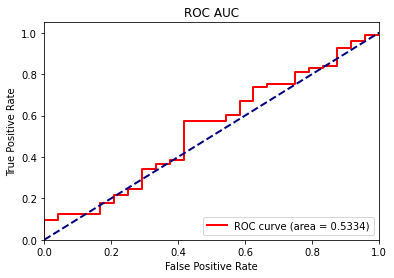

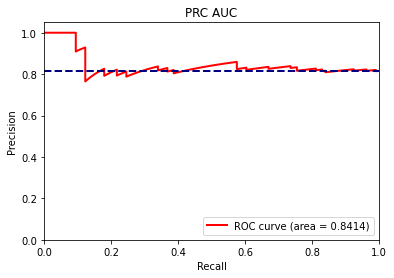

=========VALID=========
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0.724 0.781 0.805 0.778 0.769 0.766 0.753 0.78  0.8   0.759 0.766 0.769
 0.794 0.744 0.784 0.795 0.778 0.784 0.786 0.798 0.757 0.765 0.783 0.777
 0.801 0.79  0.798 0.782 0.771 0.809 0.817 0.768 0.78 ]
baseline acc: 0.8181818181818182
model pred acc: 0.8181818181818182
model pred auc: 0.38271604938271603


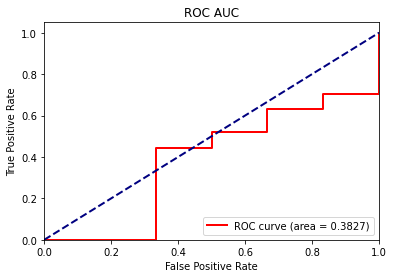

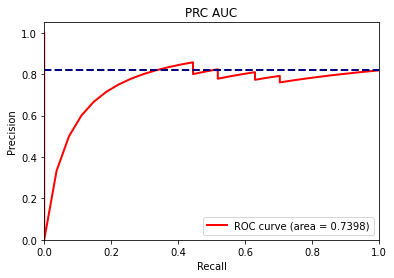

Train on 130 samples
Epoch 1/60
130/130 [==============================] - 3s 20ms/sample - loss: 1.3388 - classification_loss: 0.7082 - reconstruction_loss: 0.6076 - classification_accuracy: 0.5642 - classification_auc_2: 0.3717 - reconstruction_mean_absolute_error: 523.6524
Epoch 2/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1900 - classification_loss: 0.5622 - reconstruction_loss: 0.6075 - classification_accuracy: 0.7510 - classification_auc_2: 0.3990 - reconstruction_mean_absolute_error: 523.6494
Epoch 3/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1751 - classification_loss: 0.5479 - reconstruction_loss: 0.6042 - classification_accuracy: 0.8035 - classification_auc_2: 0.1830 - reconstruction_mean_absolute_error: 523.6410
Epoch 4/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1469 - classification_loss: 0.5695 - reconstruction_loss: 0.6015 - classification_accuracy: 0.7957 - classification_auc_2: 0.4401 - 

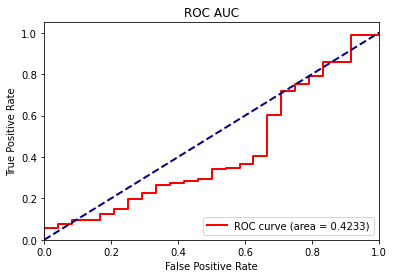

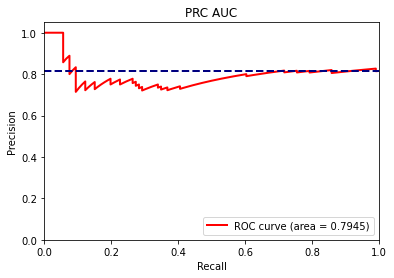

=========VALID=========
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0.766 0.785 0.785 0.787 0.798 0.776 0.772 0.786 0.764 0.782 0.763 0.769
 0.788 0.791 0.796 0.775 0.788 0.77  0.759 0.765 0.765 0.763 0.764 0.76
 0.769 0.758 0.771 0.762 0.785 0.785 0.774 0.788 0.785]
baseline acc: 0.8181818181818182
model pred acc: 0.8181818181818182
model pred auc: 0.40740740740740744


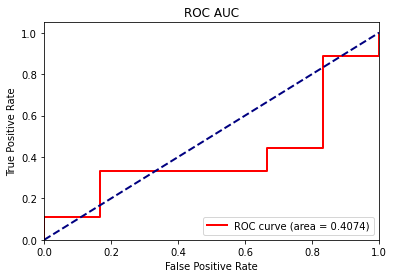

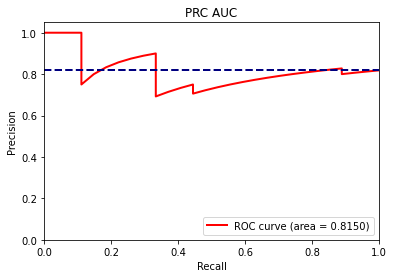

Train on 130 samples
Epoch 1/60
130/130 [==============================] - 3s 19ms/sample - loss: 1.3114 - classification_loss: 0.6769 - reconstruction_loss: 0.6060 - classification_accuracy: 0.5700 - classification_auc_3: 0.1865 - reconstruction_mean_absolute_error: 524.4277
Epoch 2/60
130/130 [==============================] - 1s 11ms/sample - loss: 1.1793 - classification_loss: 0.5507 - reconstruction_loss: 0.6054 - classification_accuracy: 0.7432 - classification_auc_3: 0.1224 - reconstruction_mean_absolute_error: 524.4245
Epoch 3/60
130/130 [==============================] - 1s 11ms/sample - loss: 1.1666 - classification_loss: 0.5344 - reconstruction_loss: 0.6110 - classification_accuracy: 0.8054 - classification_auc_3: 0.1024 - reconstruction_mean_absolute_error: 524.4156
Epoch 4/60
130/130 [==============================] - 2s 12ms/sample - loss: 1.1858 - classification_loss: 0.7058 - reconstruction_loss: 0.6129 - classification_accuracy: 0.7918 - classification_auc_3: 0.2229 - 

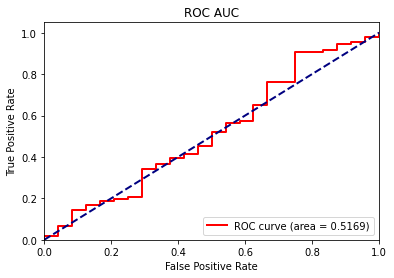

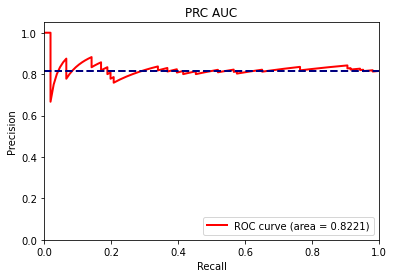

=========VALID=========
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0.782 0.824 0.625 0.764 0.754 0.814 0.733 0.649 0.727 0.671 0.745 0.769
 0.641 0.805 0.759 0.784 0.79  0.803 0.648 0.752 0.669 0.632 0.674 0.798
 0.8   0.782 0.817 0.779 0.726 0.742 0.662 0.661 0.8  ]
baseline acc: 0.8181818181818182
model pred acc: 0.8181818181818182
model pred auc: 0.5925925925925926


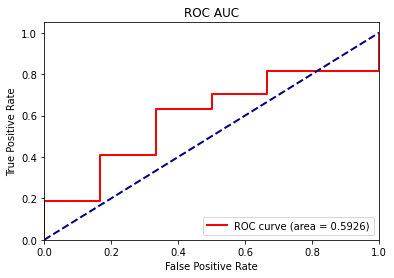

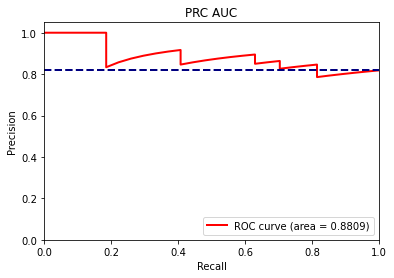

Train on 131 samples
Epoch 1/60
131/131 [==============================] - 3s 23ms/sample - loss: 1.2515 - classification_loss: 0.6416 - reconstruction_loss: 0.5900 - classification_accuracy: 0.5411 - classification_auc_4: 0.1503 - reconstruction_mean_absolute_error: 523.1312
Epoch 2/60
131/131 [==============================] - 2s 12ms/sample - loss: 1.1651 - classification_loss: 0.5867 - reconstruction_loss: 0.5944 - classification_accuracy: 0.7231 - classification_auc_4: 0.3119 - reconstruction_mean_absolute_error: 523.1287
Epoch 3/60
131/131 [==============================] - 2s 12ms/sample - loss: 1.1186 - classification_loss: 0.5395 - reconstruction_loss: 0.5898 - classification_accuracy: 0.7880 - classification_auc_4: 0.2519 - reconstruction_mean_absolute_error: 523.1214
Epoch 4/60
131/131 [==============================] - 2s 12ms/sample - loss: 1.1306 - classification_loss: 0.5543 - reconstruction_loss: 0.5980 - classification_accuracy: 0.8035 - classification_auc_4: 0.2582 - 

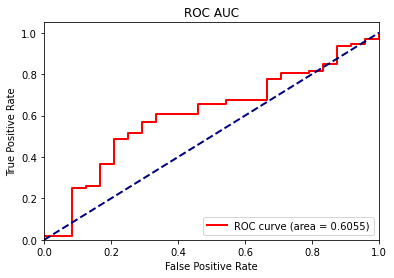

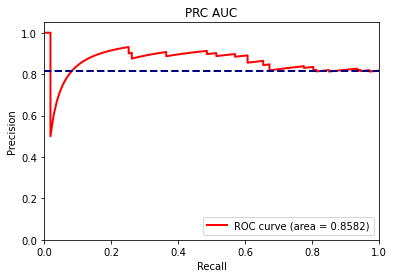

=========VALID=========
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0.819 0.785 0.732 0.817 0.864 0.779 0.806 0.83  0.789 0.835 0.727 0.745
 0.732 0.837 0.821 0.804 0.786 0.762 0.815 0.724 0.858 0.877 0.86  0.819
 0.825 0.816 0.742 0.765 0.831 0.793 0.758 0.798]
baseline acc: 0.8125
model pred acc: 0.8125
model pred auc: 0.6474358974358975


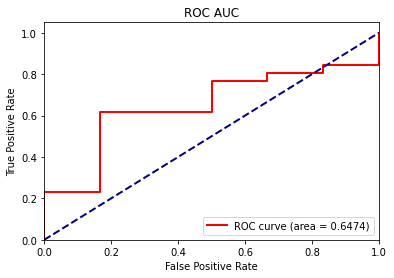

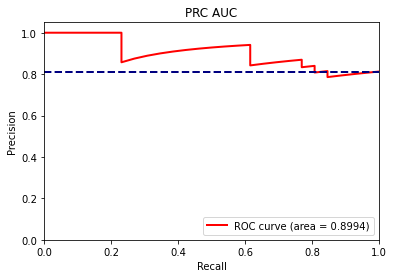

Train on 131 samples
Epoch 1/60
131/131 [==============================] - 3s 19ms/sample - loss: 1.3206 - classification_loss: 0.6670 - reconstruction_loss: 0.6358 - classification_accuracy: 0.5789 - classification_auc_5: 0.2510 - reconstruction_mean_absolute_error: 524.8732
Epoch 2/60
131/131 [==============================] - 2s 12ms/sample - loss: 1.1951 - classification_loss: 0.5431 - reconstruction_loss: 0.6362 - classification_accuracy: 0.7657 - classification_auc_5: 0.2946 - reconstruction_mean_absolute_error: 524.8704
Epoch 3/60
131/131 [==============================] - 2s 12ms/sample - loss: 1.2276 - classification_loss: 0.7446 - reconstruction_loss: 0.6531 - classification_accuracy: 0.8074 - classification_auc_5: 0.0397 - reconstruction_mean_absolute_error: 524.8627
Epoch 4/60
131/131 [==============================] - 2s 12ms/sample - loss: 1.1843 - classification_loss: 0.5345 - reconstruction_loss: 0.6395 - classification_accuracy: 0.7638 - classification_auc_5: 0.4585 - 

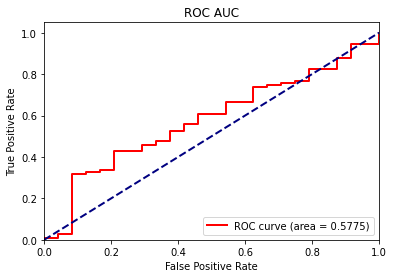

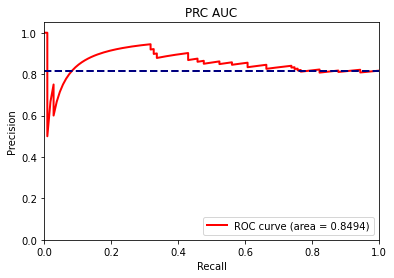

=========VALID=========
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0.767 0.775 0.769 0.77  0.768 0.771 0.767 0.761 0.769 0.773 0.765 0.77
 0.768 0.766 0.761 0.788 0.777 0.766 0.793 0.775 0.777 0.769 0.775 0.772
 0.766 0.767 0.755 0.76  0.756 0.759 0.771 0.776]
baseline acc: 0.8125
model pred acc: 0.8125
model pred auc: 0.7500000000000001


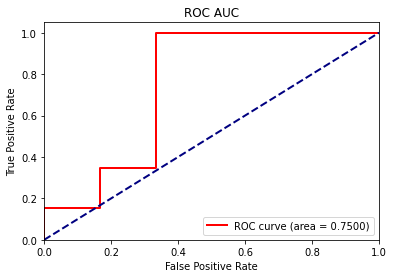

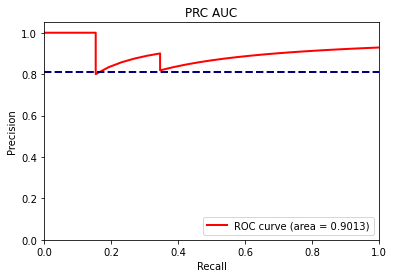

In [13]:
# --- Train Models
# modes = ['no', 'chi', 'mutual_info']
modes = ['no']
for mode in modes:
    history, model = run_pipeline(dataset, mode)

In [10]:
def recon(model, dataset, i, n):
    print(model.predict(dataset.xte)[1].squeeze()[i, :n])
    print(dataset.xte.squeeze()[i, :n])
    
recon(model, dataset, 9, 8)

[  0.    168.366  33.259   2.881   0.      0.      0.     11.897]
[  0.    136.131  33.769   7.387   0.      0.      0.     12.663]


# Machine Learning Stuff...

In [14]:
def default_dataset():
    path = 'data/ctrl_vs_case.csv'
    dataset = Dataset(path, train_size=0.7)
    dataset.feature_selection(mode='no')
    return dataset

In [15]:
# dataset = default_dataset()
Xtr, Xte, Ytr, Yte = [np.array(data.squeeze()) for data in [dataset.xtr, dataset.xte, dataset.ytr, dataset.yte]]

In [30]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold


def cross_valid(model, dataset, n_folds=5):
    x = dataset.features_
    y = dataset.labels
    kf = StratifiedKFold(n_splits=n_folds)

    for train_index, test_index in kf.split(x, y):
        xtr, xte = x[train_index], x[test_index]
        ytr, yte = y[train_index], y[test_index]
        data = (xtr.squeeze(), ytr, xte.squeeze(), yte)
        model(*data)
        
    return model


def pca(x, n=100, verbose=False):
    model = PCA(n).fit(x)
    if verbose:
        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.xlabel('n components')
        plt.ylabel('cumulative variance');
    return model


def hard_predict(model, x):
    return model.predict(x)


def soft_predict(model, x):
    return model.predict_proba(x)[:, 1]


def plot_curves(model, x, y):
    pred = hard_predict(model, x)
    conf_scores = soft_predict(model, x)
    plot_auc(y, conf_scores, mode='roc', lw=2)
    plot_auc(y, conf_scores, mode='prc', lw=2)
    
    
def results(model, xtr, ytr, xte, yte):
    print('==================')
    print('baseline train acc: {}'.format(class_one_acc(ytr)))
    print('baseline test acc : {}'.format(class_one_acc(yte)))
    print()
    hptr = hard_predict(model, xtr)
    hpte = hard_predict(model, xte)
    print('model train acc: {}'.format(acc(ytr, hptr)))
    print('model test acc: {}'.format(acc(yte, hpte)))
    print()
    sptr = soft_predict(model, xtr)
    spte = soft_predict(model, xte)
    print('model train auc: {}'.format(roc_auc(ytr, sptr)))
    print('model test auc: {}'.format(roc_auc(yte, spte)))
    print('==================')
    
    print('Test-set')
    plot_curves(model, xte, yte)
    

def knn(xtr, ytr, xte, yte, n=3):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)
    
    
def rf(xtr, ytr, xte, yte, d=2):
    model = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0, class_weight='balanced')
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)
    
def dt(xtr, ytr, xte, yte):
    model = DecisionTreeClassifier()
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)

In [ ]:
def demo(Xtr, Xte, Ytr, Yte):
    # pca
    pc = pca(Xtr)
    xtr = pc.transform(Xtr)
    xte = pc.transform(Xte)
    print(Xtr.shape, xtr.shape)

    print('- KNN')
    knn(Xtr, Ytr, Xte, Yte)
    print('- PCA')
    knn(xtr, Ytr, xte, Yte)
    print()
    print('- RF')
    rf(Xtr, Ytr, Xte, Yte)
    print('- PCA')
    rf(xtr, Ytr, xte, Yte)
    print()
    print('- DT')
    dt(Xtr, Ytr, Xte, Yte)
    print('- PCA')
    dt(xtr, Ytr, xte, Yte)
    
demo(Xtr, Xte, Ytr, Yte)

In [ ]:
cross_valid(dt, dataset, n_folds=5)

0.9570437675991725

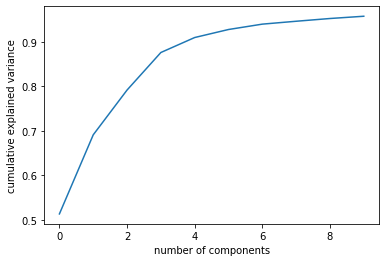

In [18]:
# TODO: check representational power of PCA features

dataset.pca(n_components=10, verbose=True)
np.sum(dataset.pca_.explained_variance_ratio_)

In [19]:
pca_importance(dataset)

,pc,feature
0,pc-1,X7SK.4
1,pc-2,MT.RNR2
2,pc-3,MALAT1
3,pc-4,RN7SL2
4,pc-5,NEFL
5,pc-6,COL3A1
6,pc-7,MAP1B
7,pc-8,COL3A1
8,pc-9,EEF2
9,pc-10,SNORD3C


In [ ]:
# One pass through training split

def demo(Xtr, Xte, Ytr, Yte):
    pc = pca(Xtr)
    xtr = pc.transform(Xtr)
    xte = pc.transform(Xte)
    print(Xtr.shape, xtr.shape)

    print('- KNN')
    knn(Xtr, Ytr, Xte, Yte)
    print('- PCA')
    knn(xtr, Ytr, xte, Yte)
    print()
    print('- RF')
    rf(Xtr, Ytr, Xte, Yte)
    print('- PCA')
    rf(xtr, Ytr, xte, Yte)
    print()
    print('- DT')
    dt(Xtr, Ytr, Xte, Yte)
    print('- PCA')
    dt(xtr, Ytr, xte, Yte)
    
demo(Xtr, Xte, Ytr, Yte)